# Quality control and clustering of scRNA-seq data from endometriosis and control samples from mentrual blood (GSE203191)

In [34]:
from pathlib import Path
import scanpy as sc
import pandas as pd
import numpy as np
!pip install openpyxl

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]


In [ ]:
base = Path("/home/katwre/projects/Endometriosis/data/GSE203191_RAW/")
files = list(base.glob("*.h5"))

adatas = []
for f in files:
    ad = sc.read_10x_h5(f)
    ad.var_names_make_unique()
    ad.obs["sample_id"] = f.stem
    adatas.append(ad)

adata_all = adatas[0].concatenate(
    *adatas[1:],
    batch_key="sample",
    batch_categories=[f.stem for f in files]
)
adata_all

/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_du

AnnData object with n_obs × n_vars = 77917 × 33538
    obs: 'sample_id', 'sample'
    var: 'gene_ids', 'feature_types', 'genome'

In [39]:
print(adata_all)
#print(adata_all.obs.head())
#print(adata_all.obs.columns)

AnnData object with n_obs × n_vars = 77917 × 33538
    obs: 'sample_id', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_res_0.02', 'leiden_res_0.50', 'leiden_res_2.00', 'celltype_res_2.00', 'confidence_res_2.00'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'sampl

In [5]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata_all.var["mt"] = adata_all.var_names.str.startswith("MT-")
# ribosomal genes
adata_all.var["ribo"] = adata_all.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata_all.var["hb"] = adata_all.var_names.str.contains("^HB[^(P)]")
sc.pp.calculate_qc_metrics(adata_all, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

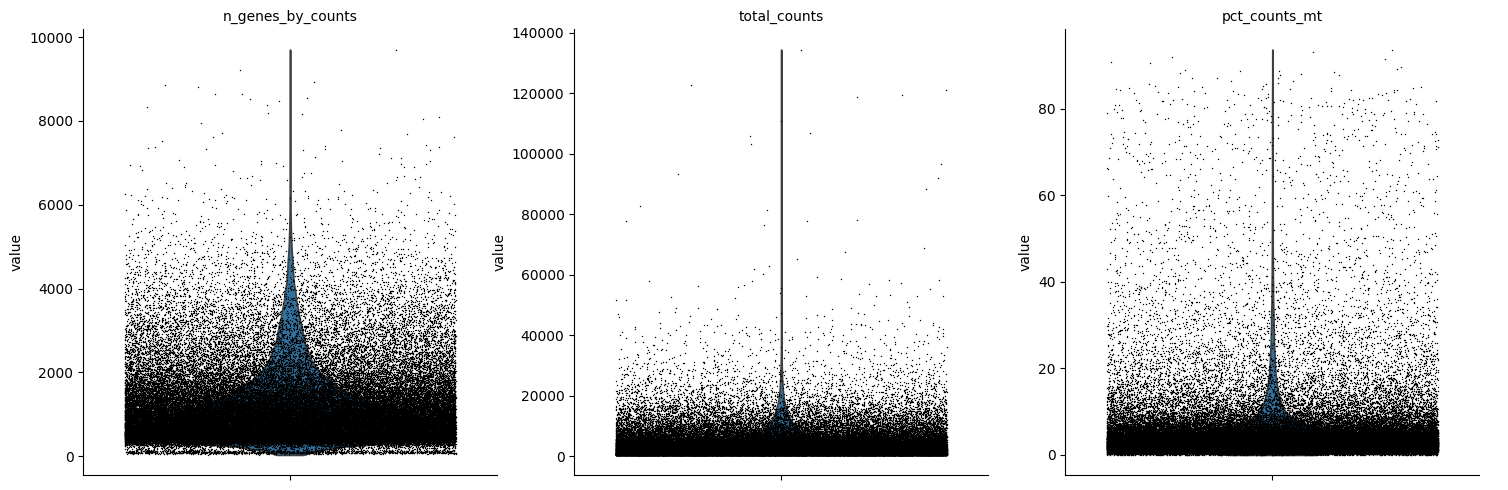

In [6]:
sc.pl.violin(
    adata_all,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)


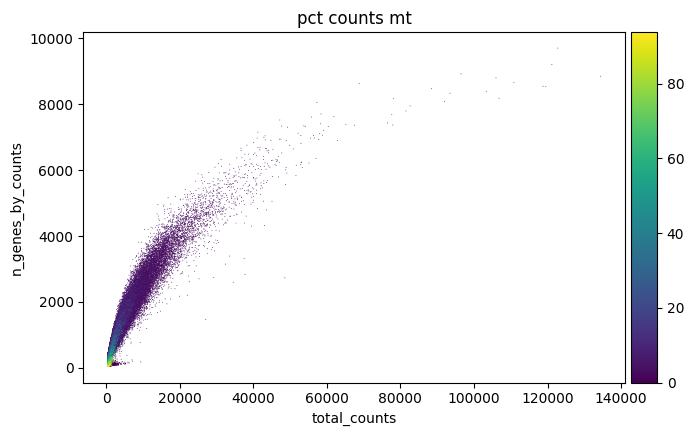

In [7]:
sc.pl.scatter(adata_all, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [8]:
# Doublet detection
sc.pp.scrublet(adata_all, batch_key="sample")

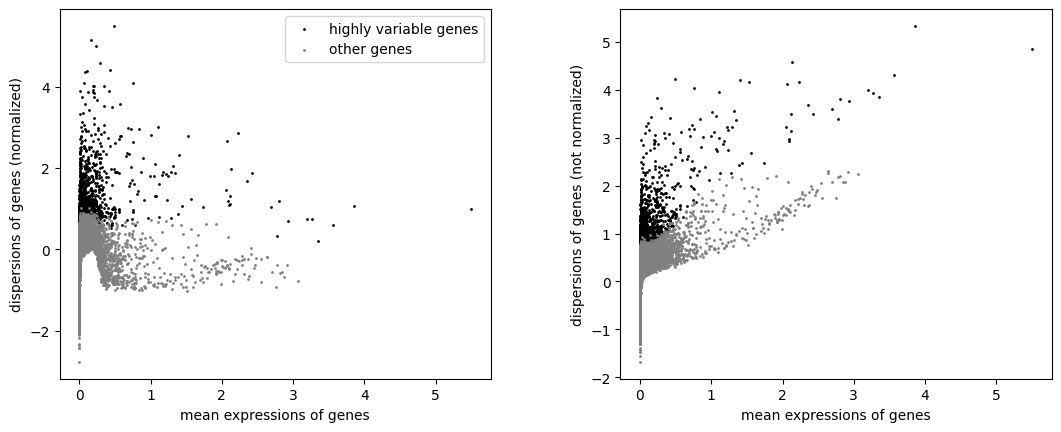

In [9]:
# Normalization
# Saving count data
adata_all.layers["counts"] = adata_all.X.copy()

# Normalizing to median total counts
sc.pp.normalize_total(adata_all)
# Logarithmize the data
sc.pp.log1p(adata_all)

# Feature selection
# we want to reduce the dimensionality of the dataset and only include the most informative genes.

# Identify highly variable genes
sc.pp.highly_variable_genes(adata_all, n_top_genes=2000, batch_key="sample")
sc.pl.highly_variable_genes(adata_all)

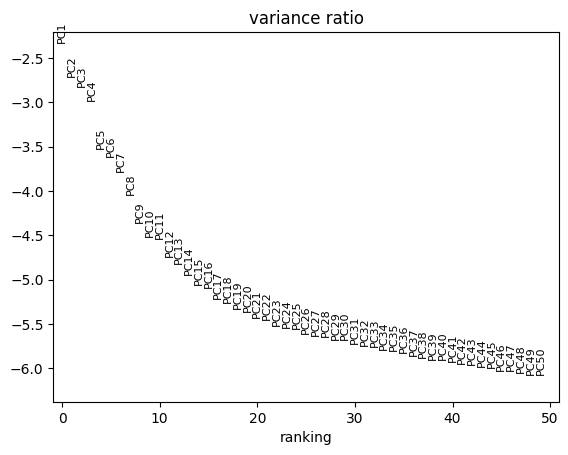

In [10]:
# Dimensionality Reduction
sc.tl.pca(adata_all)
sc.pl.pca_variance_ratio(adata_all, n_pcs=50, log=True)

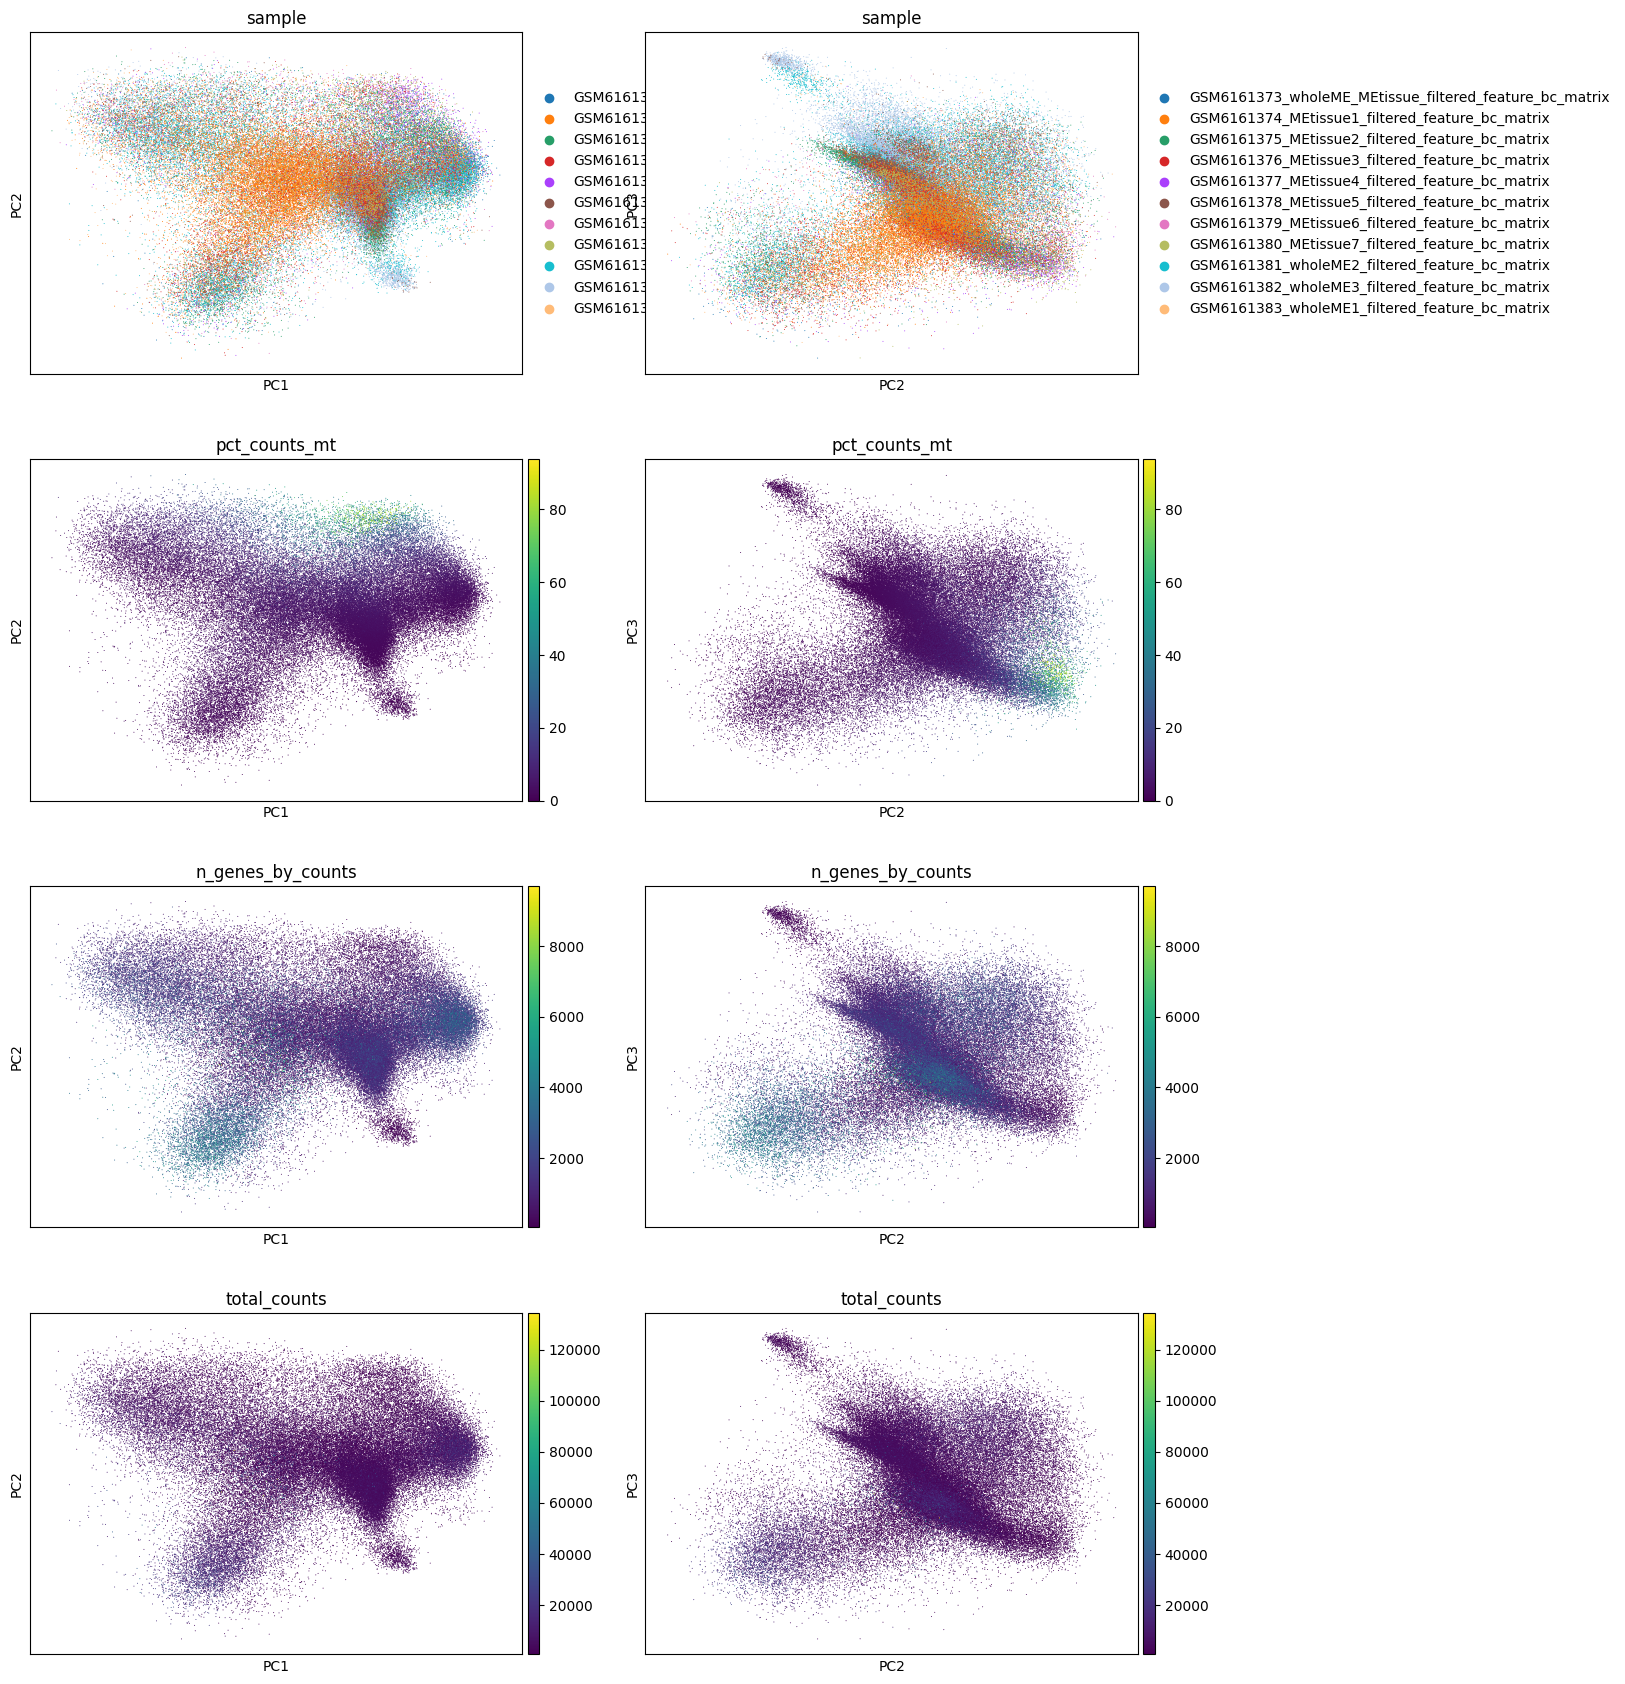

In [44]:
sc.pl.pca(
    adata_all,
    color=["sample", "pct_counts_mt", "n_genes_by_counts", "total_counts"],
    components=["1,2", "2,3"],
    ncols=2,
    size=2,
)

/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


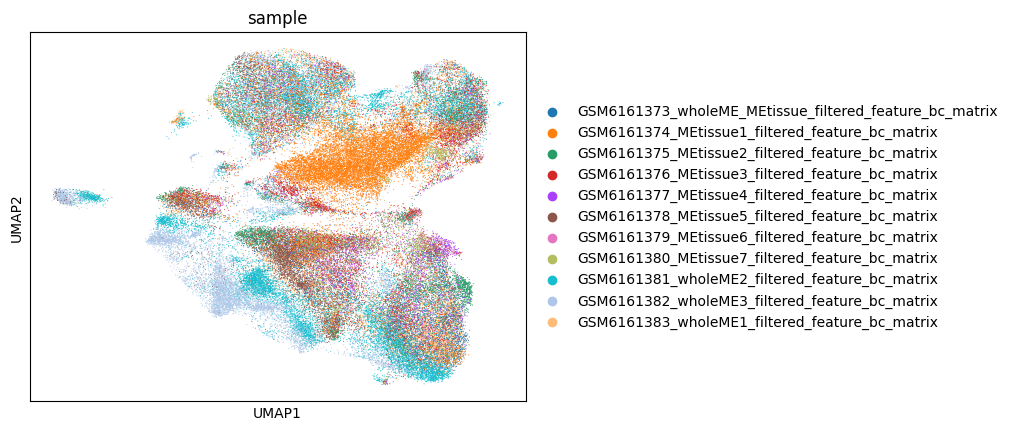

In [ ]:
# Nearest neighbor graph construction and visualization
sc.pp.neighbors(adata_all)
sc.tl.umap(adata_all)
sc.pl.umap(
    adata_all,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

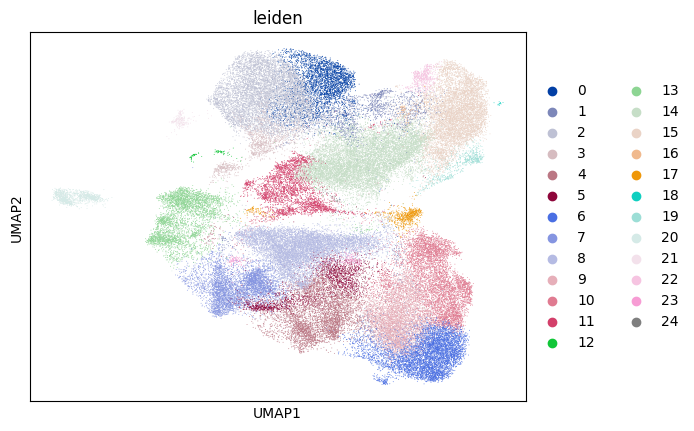

In [13]:
# Clustering

# Using the igraph implementation and a fixed number of iterations can be significantly faster,
# especially for larger datasets
sc.tl.leiden(adata_all, flavor="igraph", n_iterations=2)
sc.pl.umap(adata_all, color=["leiden"])


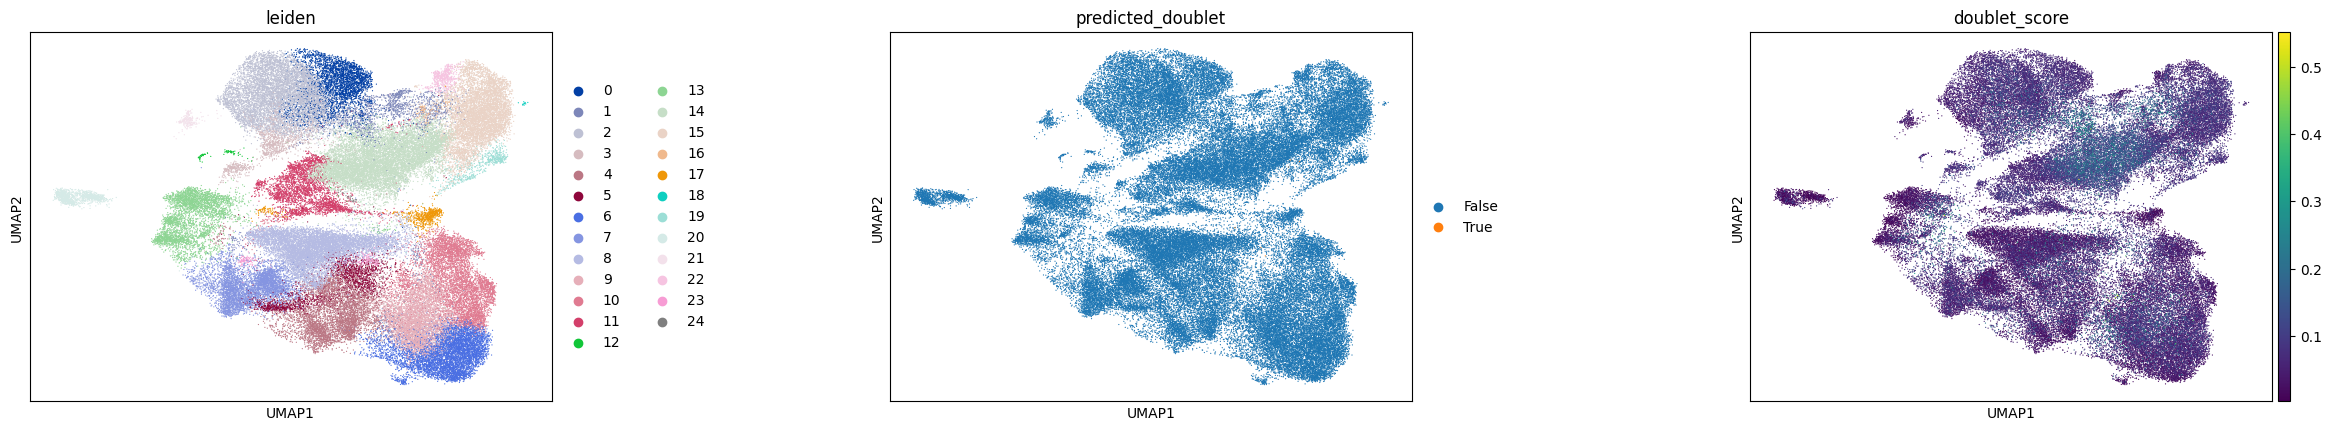

In [14]:
# Re-assess quality control and cell filtering
sc.pl.umap(
    adata_all,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)


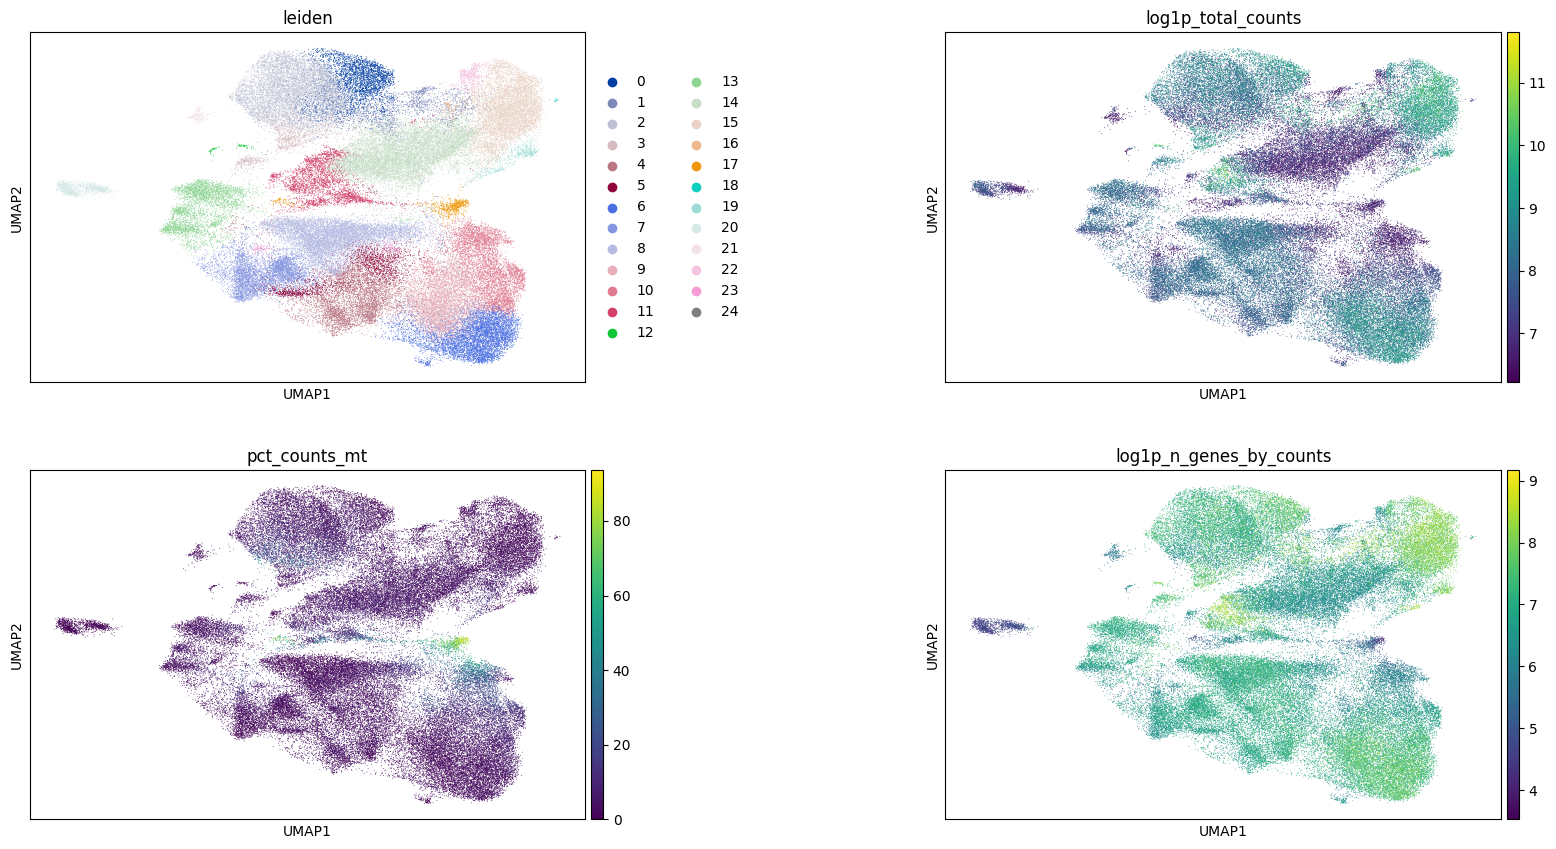

In [15]:
sc.pl.umap(
    adata_all,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

In [ ]:
adata_all.write_h5ad(
    "/home/katwre/projects/Endometriosis/data/processed/01_processed_qc_clustering_GSE203191_RAW.h5ad"
)

In [ ]:
# Manual cell-type annotation

for res in [0.02, 0.5, 2.0]:
    sc.tl.leiden(adata_all, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph")

# Leiden is a graph-based clustering algorithm widely used in single-cell RNA-seq analysis.
# It finds groups of cells based on similarity in the PCA/neighbor graph.

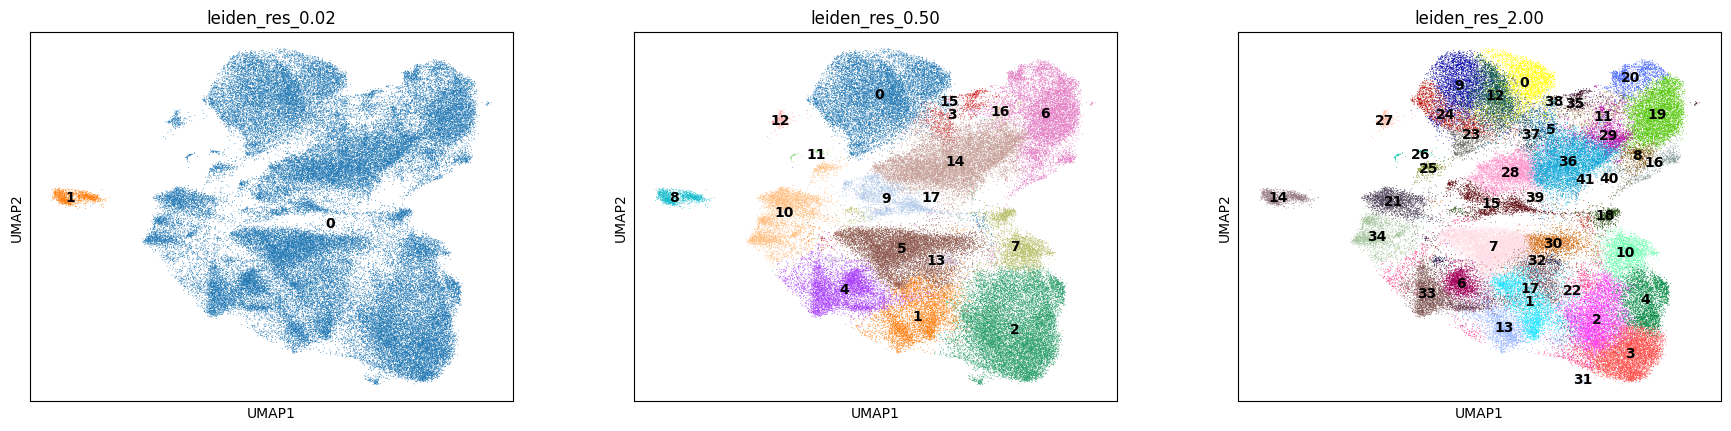

In [18]:
sc.pl.umap(
    adata_all,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_2.00"],
    legend_loc="on data",
)

In [30]:
marker_genes = {
    "Uterine natural killer cells": [
        "PTPRC", "NCAM1"
    ],
    "Stromal cells": [
        "NT5E", "Thy1",  "CD90", "ENG"
    ],
    "CD4+ T cells": [
        "PTPRC", "CD3D", "CD3E", "CD4"
    ],
    "Myeloid cells": [
        "PTPRC", "CD14"
    ],
    "Epithelial cells": [
        "EPCAM"
    ],
    "CD8+ T cells": [
        "PTPRC", "CD3D", "CD3E", "CD8A"
    ],
    "B cells": [
        "PTPRC", "CD19", "MS4A1"
    ],
    "Plasmacytoid dendritic cells": [
        "PTPRC", "IL3RA", "CLEC4C", "LILRA4"
    ],
    "Endothelial-like cells": [
        "ENG", "PECAM1", "CD34"
    ],
    "Granulocytes": [
        "GCSAML", "CPA3"
    ],
    "Unknown Immune cells": [
        "PTPRC"
    ]
}

for celltype, genes in marker_genes.items():
    present = [g for g in genes if g in adata_all.var_names]
    missing = [g for g in genes if g not in adata_all.var_names]
    if missing:
        print(f"{celltype}:")
        print(f"  present: {present}")
        print(f"  missing: {missing}")

# Remove missing genes from marker list
marker_genes_filtered = {
    ct: [g for g in genes if g in adata_all.var_names]
    for ct, genes in marker_genes.items()
}

Stromal cells:
  present: ['NT5E', 'ENG']
  missing: ['Thy1', 'CD90']


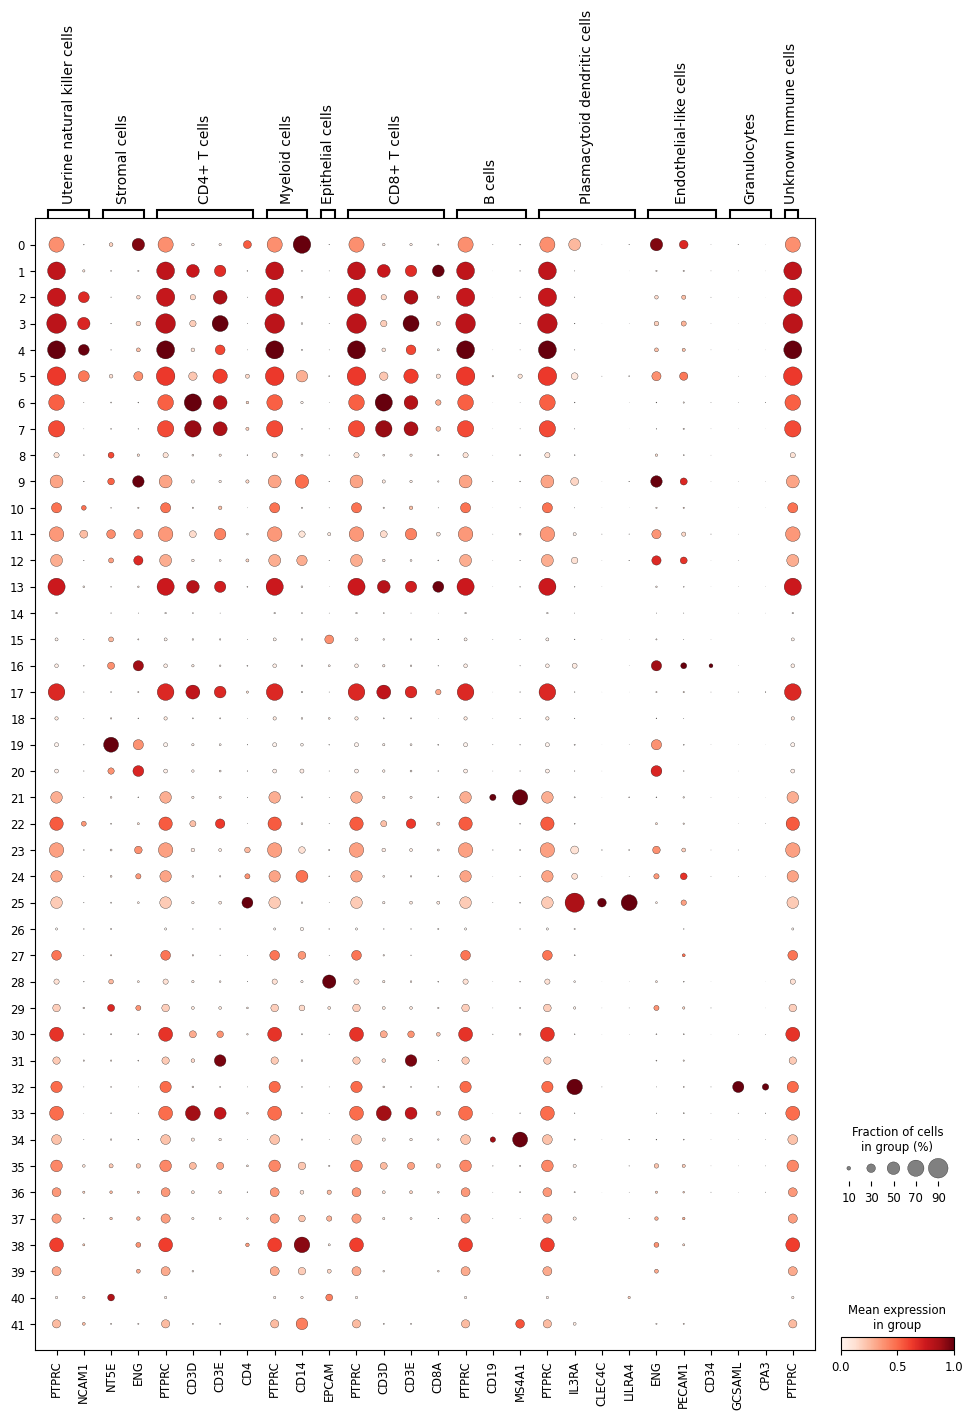

In [20]:
sc.pl.dotplot(
    adata_all,
    marker_genes_filtered,
    groupby="leiden_res_2.00",
    standard_scale="var"
)


In [ ]:
# Make sure leiden_res_0.50 is a string
adata_all.obs["leiden_res_2.00"] = adata_all.obs["leiden_res_2.00"].astype(str)

# Group mean expression for all genes
cluster_means = adata_all.to_df().groupby(adata_all.obs["leiden_res_2.00"]).mean()

scores = {}

for celltype, genes in marker_genes_filtered.items():
    present_genes = [g for g in genes if g in cluster_means.columns]
    # Mean expression across marker genes for each cluster
    scores[celltype] = cluster_means[present_genes].mean(axis=1)

scores = pd.DataFrame(scores)
scores.head()


Uterine natural killer cells  Stromal cells  CD4+ T cells  \
leiden_res_2.00                                                              
0                                    0.251993       0.188224      0.173940   
1                                    0.512296       0.014259      0.488512   
10                                   0.393346       0.026926      0.191404   
11                                   0.279422       0.124983      0.202891   
12                                   0.198106       0.171883      0.124363   

                 Myeloid cells  Epithelial cells  CD8+ T cells   B cells  \
leiden_res_2.00                                                            
0                     0.870896          0.008391      0.143847  0.169569   
1                     0.500164          0.003953      0.604106  0.331644   
10                    0.318079          0.008414      0.192308  0.202432   
11                    0.299477          0.044251      0.210672  0.160793   
12                    0.383803          0.004849      0.117266  0.132218   

                 Plasmacytoid dendritic cells  Endothelial-like cells  \
leiden_res_2.00                                                         
0                                    0.201995                0.160670   
1                                    0.247796                0.011636   
10                                   0.152106                0.023737   
11                                   0.125295                0.053410   
12                                   0.134779                0.128458   

                 Granulocytes  Unknown Immune cells  
leiden_res_2.00                                      
0                    0.001541              0.498108  
1                    0.000619              0.987468  
10                   0.000593              0.602728  
11                   0.000569              0.465565  
12                   0.000590              0.391445

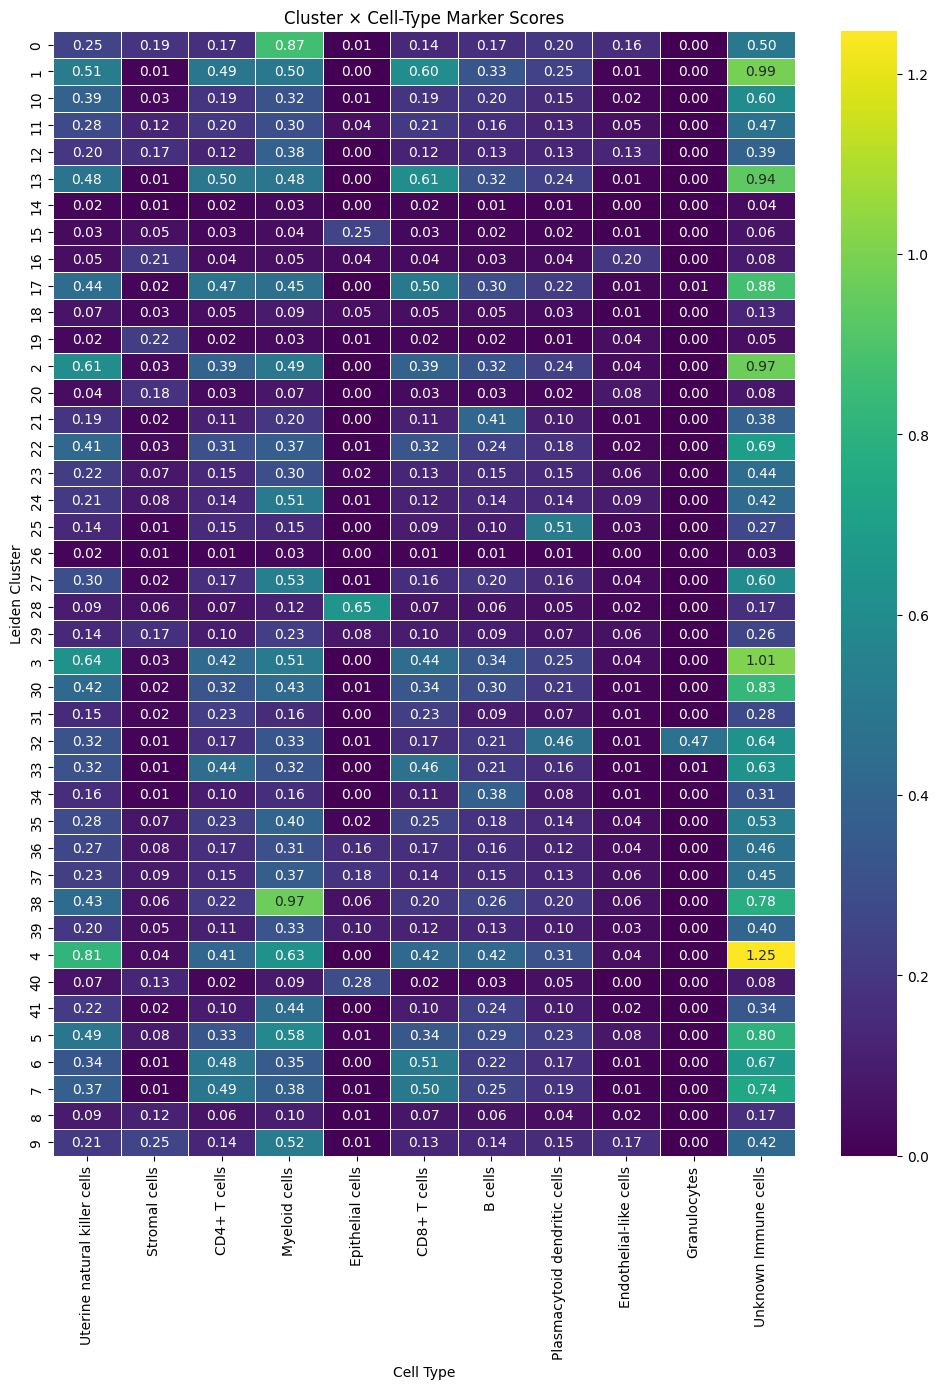

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 14))
sns.heatmap(
    scores,
    cmap="viridis",          # or "magma", "plasma", "coolwarm"
    linewidths=0.5,
    annot=True,              # write numbers in cells
    fmt=".2f"
)
plt.title("Cluster × Cell-Type Marker Scores")
plt.xlabel("Cell Type")
plt.ylabel("Leiden Cluster")
plt.tight_layout()
plt.show()

In [26]:
cluster_annotations = pd.DataFrame({
    "cluster": scores.index,
    "assigned_celltype": scores.idxmax(axis=1),
    "score": scores.max(axis=1),
})
cluster_annotations


cluster             assigned_celltype     score
leiden_res_2.00                                                
0                     0                 Myeloid cells  0.870896
1                     1          Unknown Immune cells  0.987468
10                   10          Unknown Immune cells  0.602728
11                   11          Unknown Immune cells  0.465565
12                   12          Unknown Immune cells  0.391445
13                   13          Unknown Immune cells  0.938789
14                   14          Unknown Immune cells  0.037788
15                   15              Epithelial cells  0.251777
16                   16                 Stromal cells  0.210853
17                   17          Unknown Immune cells  0.875639
18                   18          Unknown Immune cells  0.127829
19                   19                 Stromal cells  0.223762
2                     2          Unknown Immune cells  0.965653
20                   20                 Stromal cells  0.179065
21                   21                       B cells  0.409488
22                   22          Unknown Immune cells  0.690944
23                   23          Unknown Immune cells  0.438958
24                   24                 Myeloid cells  0.510101
25                   25  Plasmacytoid dendritic cells  0.514839
26                   26          Unknown Immune cells  0.031600
27                   27          Unknown Immune cells  0.597319
28                   28              Epithelial cells  0.651412
29                   29          Unknown Immune cells  0.257555
3                     3          Unknown Immune cells  1.005792
30                   30          Unknown Immune cells  0.828869
31                   31          Unknown Immune cells  0.277055
32                   32          Unknown Immune cells  0.635816
33                   33          Unknown Immune cells  0.628806
34                   34                       B cells  0.377558
35                   35          Unknown Immune cells  0.528704
36                   36          Unknown Immune cells  0.464077
37                   37          Unknown Immune cells  0.445466
38                   38                 Myeloid cells  0.969105
39                   39          Unknown Immune cells  0.401342
4                     4          Unknown Immune cells  1.246793
40                   40              Epithelial cells  0.283451
41                   41                 Myeloid cells  0.443195
5                     5          Unknown Immune cells  0.802558
6                     6          Unknown Immune cells  0.668384
7                     7          Unknown Immune cells  0.743340
8                     8          Unknown Immune cells  0.165707
9                     9                 Myeloid cells  0.517302

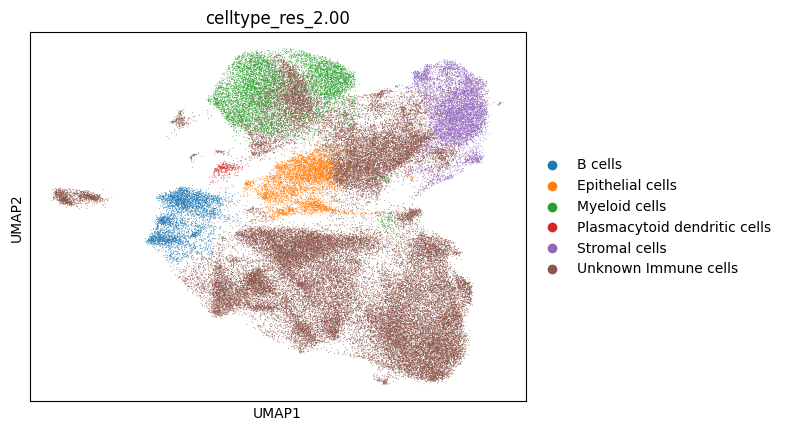

In [27]:
# Create a dictionary mapping cluster → annotation
mapping = cluster_annotations.set_index("cluster")["assigned_celltype"].to_dict()
adata_all.obs["celltype_res_2.00"] = adata_all.obs["leiden_res_2.00"].map(mapping)
sc.pl.umap(adata_all, color="celltype_res_2.00")


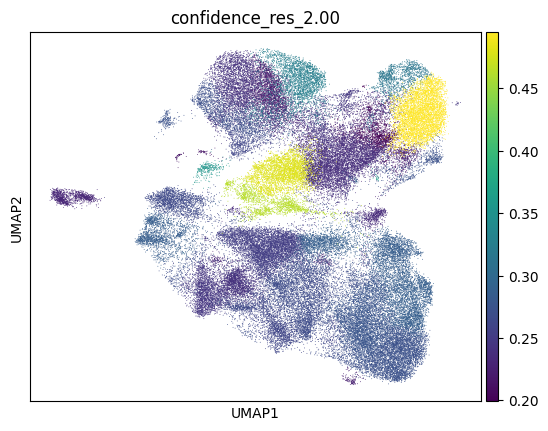

In [28]:
cluster_annotations["confidence"] = cluster_annotations["score"] / scores.sum(axis=1)
confidence_map = (
    cluster_annotations.set_index("cluster")["confidence"].to_dict()
)
adata_all.obs["confidence_res_2.00"] = (
    adata_all.obs["leiden_res_2.00"].map(confidence_map).astype(float)
)
sc.pl.umap(
    adata_all,
    color=["confidence_res_2.00"],
    cmap="viridis"
)

Using the marker genes provided in Supplementary File 2, I was not able to fully recapitulate the cluster identities shown in Figure 2, likely due to differences in preprocessing, clustering resolution, or marker expression thresholds. For now, I will continue with the current annotations and refine them as I further explore endometrial and endometriosis biology.

In [31]:
adata_all.write_h5ad(
    "/home/katwre/projects/Endometriosis/data/processed/01_processed_qc_clustering.h5ad"
)

# Limitations

A key limitation I just discovered is that the dataset does not provide enough information to reliably separate samples into control, symptomatic, and endometriosis groups.

In [101]:
# Color-code by endometriosis and control - it's not possible since authors of the publication 
# didn't provide any clues ohw to map their samples to disease

meta = pd.read_excel("/home/katwre/projects/Endometriosis/data/GSE203191_metadata.xlsx", 
                     sheet_name="2. Metadata",
                     skiprows=41)
meta.head()

library name                title      organism    tissue    phenotype  \
0     Sample 1  TB13020946-MEtissue  Home sapiens  MEtissue      Control   
1     Sample 2  TB13021438-MEtissue  Home sapiens  MEtissue  Symptomatic   
2     Sample 3  TB13020849-MEtissue  Home sapiens  MEtissue  Symptomatic   
3     Sample 4  TB13021372-MEtissue  Home sapiens  MEtissue      Control   
4     Sample 5  TB13021252-MEtissue  Home sapiens  MEtissue  Symptomatic   

    subjectID molecule single or paired-end instrument model   description  \
0  TB13020946      rna           Paired-end      NextSeq 500  10x Genomics   
1  TB13021438      rna           Paired-end      NextSeq 500  10x Genomics   
2  TB13020849      rna           Paired-end      NextSeq 500  10x Genomics   
3  TB13021372      rna           Paired-end      NextSeq 500  10x Genomics   
4  TB13021252      rna           Paired-end      NextSeq 500  10x Genomics   

      description.1                            processed data file   
0  wholeME_MEtissue  wholeME_MEtissue_filtered_feature_bc_matrix.h5  
1  wholeME_MEtissue  wholeME_MEtissue_filtered_feature_bc_matrix.h5  
2  wholeME_MEtissue  wholeME_MEtissue_filtered_feature_bc_matrix.h5  
3         MEtissue1         MEtissue1_filtered_feature_bc_matrix.h5  
4         MEtissue1         MEtissue1_filtered_feature_bc_matrix.h5

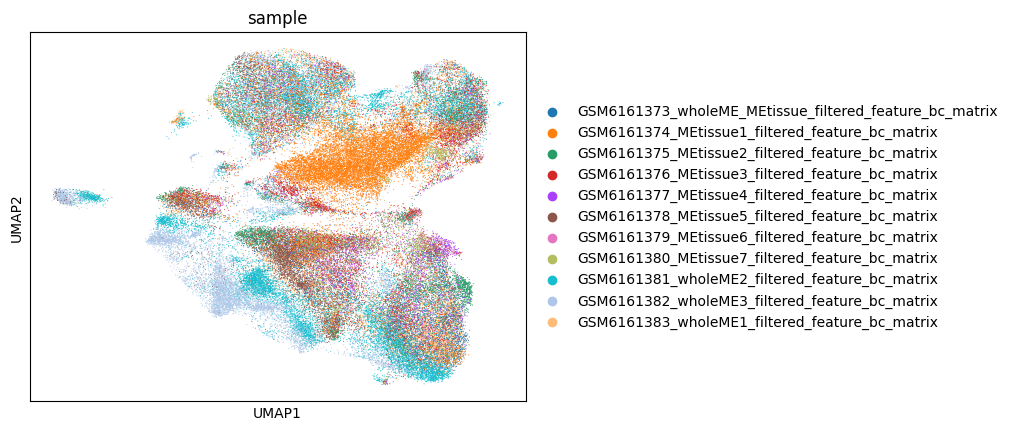

In [103]:
sc.pl.umap(
    adata_all,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

It looks like I can only detect a few diagnosed samples, so I will try to see if there are any differences between them and all other samples.

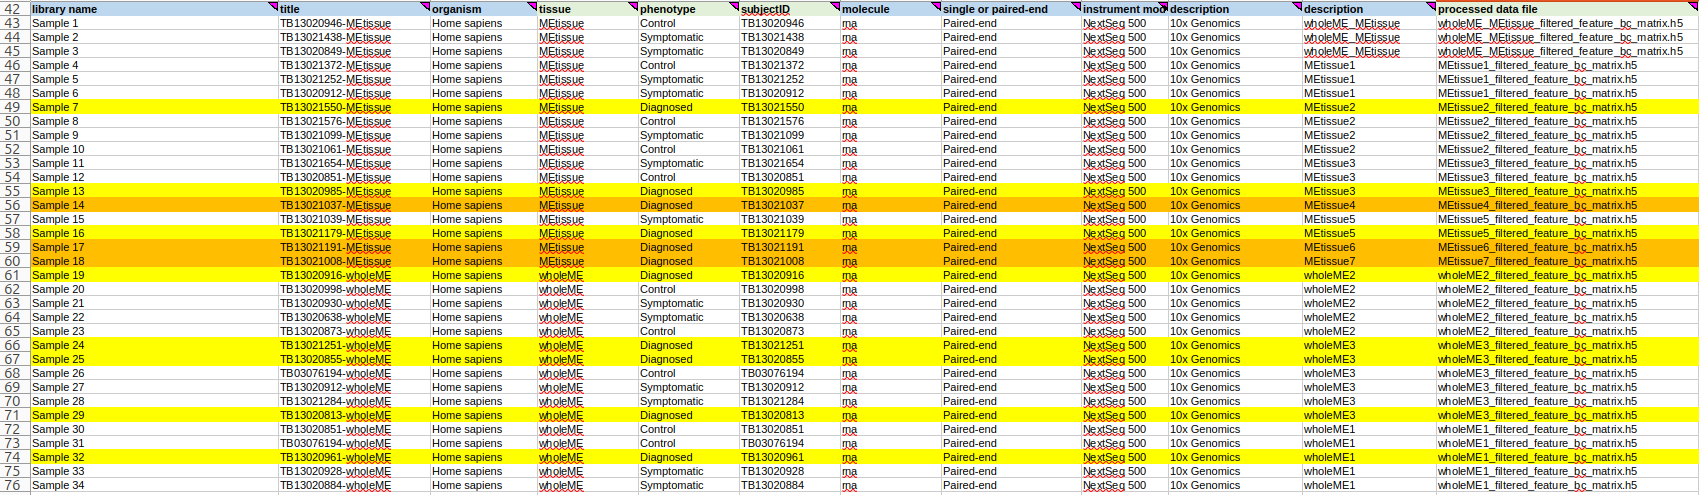

In [ ]:
from IPython.display import Image
Image("/home/katwre/projects/Endometriosis/img/meta.png")

I will further assess whether the diagnosed samples exhibit the gene signature enrichments reported by the authors.

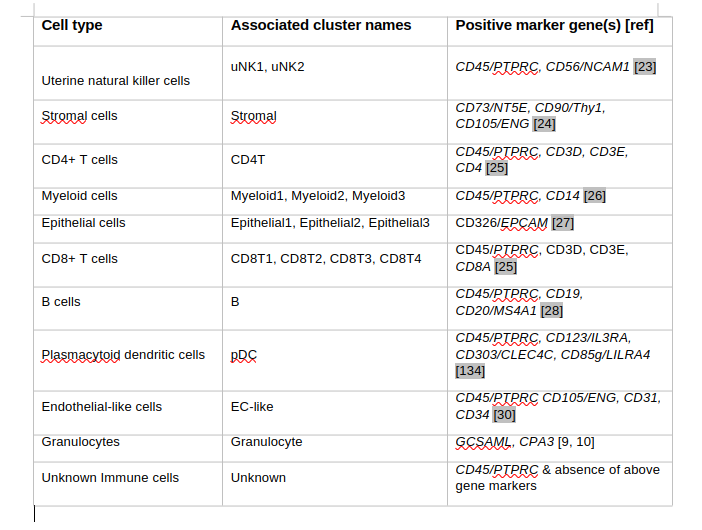

In [116]:
Image("/home/katwre/projects/Endometriosis/img/known_marker_genes.png")

In [ ]:
diagnosed = ["MEtissue4_filtered_feature_bc_matrix.h5",
             "MEtissue6_filtered_feature_bc_matrix.h5",
             "MEtissue7_filtered_feature_bc_matrix.h5"] 
diagnosed_prefix = [x.replace("_filtered_feature_bc_matrix.h5", "") for x in diagnosed]

pattern = "|".join(diagnosed_prefix)

adata_diagnosed = adata_all[
    adata_all.obs["sample"].str.contains(pattern),
    :
].copy()

print(adata_diagnosed.obs["sample"].unique())

['GSM6161379_MEtissue6_filtered_feature_bc_matrix', 'GSM6161377_MEtissue4_filtered_feature_bc_matrix', 'GSM6161380_MEtissue7_filtered_feature_bc_matrix']
Categories (3, object): ['GSM6161377_MEtissue4_filtered_feature_bc_matrix', 'GSM6161379_MEtissue6_filtered_feature_bc_matrix', 'GSM6161380_MEtissue7_filtered_feature_bc_matrix']


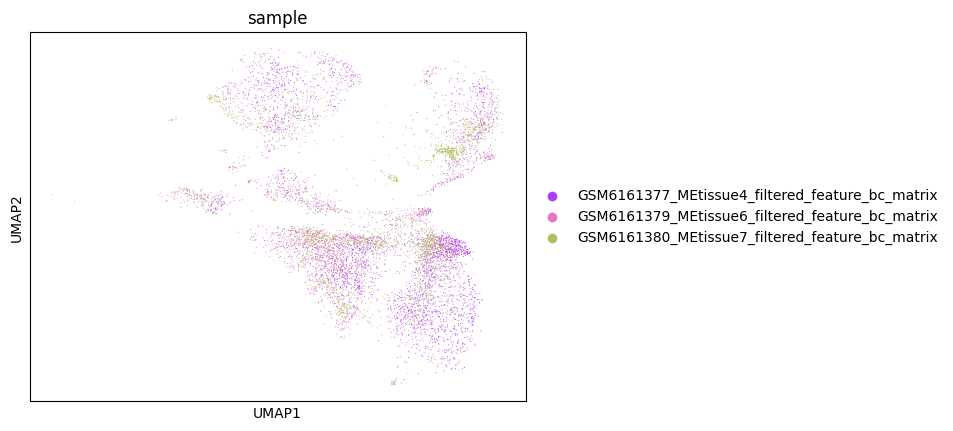

In [ ]:
sc.pl.umap(
    adata_diagnosed,
    color="sample",
    size=2,
)

In [106]:
# Score each signature per cell type
for sig_name, genes in marker_genes.items():
    valid_genes = [g for g in genes if g in adata_all.var_names]
    sc.tl.score_genes(adata_all, valid_genes, score_name=f"{sig_name}_score")

# Aggregate scores per sample
scores_per_sample = (
    adata_all.obs
    .groupby("sample")[
        [col for col in adata_all.obs.columns if col.endswith("_score")]
    ]
    .mean()
)
scores_per_sample.head()

/tmp/ipykernel_1999416/2067026422.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("sample")[


doublet_score  \
sample                                                              
GSM6161373_wholeME_MEtissue_filtered_feature_bc...       0.062042   
GSM6161374_MEtissue1_filtered_feature_bc_matrix          0.086315   
GSM6161375_MEtissue2_filtered_feature_bc_matrix          0.057025   
GSM6161376_MEtissue3_filtered_feature_bc_matrix          0.049492   
GSM6161377_MEtissue4_filtered_feature_bc_matrix          0.056160   

                                                    Uterine natural killer cells_score  \
sample                                                                                   
GSM6161373_wholeME_MEtissue_filtered_feature_bc...                            0.295509   
GSM6161374_MEtissue1_filtered_feature_bc_matrix                               0.043857   
GSM6161375_MEtissue2_filtered_feature_bc_matrix                               0.195529   
GSM6161376_MEtissue3_filtered_feature_bc_matrix                               0.045728   
GSM6161377_MEtissue4_filtered_feature_bc_matrix                               0.181558   

                                                    Stromal cells_score  \
sample                                                                    
GSM6161373_wholeME_MEtissue_filtered_feature_bc...            -0.018931   
GSM6161374_MEtissue1_filtered_feature_bc_matrix                0.012076   
GSM6161375_MEtissue2_filtered_feature_bc_matrix               -0.013420   
GSM6161376_MEtissue3_filtered_feature_bc_matrix                0.003620   
GSM6161377_MEtissue4_filtered_feature_bc_matrix               -0.014767   

                                                    CD4+ T cells_score  \
sample                                                                   
GSM6161373_wholeME_MEtissue_filtered_feature_bc...            0.161223   
GSM6161374_MEtissue1_filtered_feature_bc_matrix              -0.026670   
GSM6161375_MEtissue2_filtered_feature_bc_matrix               0.104019   
GSM6161376_MEtissue3_filtered_feature_bc_matrix              -0.005839   
GSM6161377_MEtissue4_filtered_feature_bc_matrix               0.049195   

                                                    Myeloid cells_score  \
sample                                                                    
GSM6161373_wholeME_MEtissue_filtered_feature_bc...             0.096633   
GSM6161374_MEtissue1_filtered_feature_bc_matrix               -0.072687   
GSM6161375_MEtissue2_filtered_feature_bc_matrix                0.014428   
GSM6161376_MEtissue3_filtered_feature_bc_matrix               -0.099039   
GSM6161377_MEtissue4_filtered_feature_bc_matrix                0.018077   

                                                    Epithelial cells_score  \
sample                                                                       
GSM6161373_wholeME_MEtissue_filtered_feature_bc...               -0.050050   
GSM6161374_MEtissue1_filtered_feature_bc_matrix                   0.146163   
GSM6161375_MEtissue2_filtered_feature_bc_matrix                  -0.048286   
GSM6161376_MEtissue3_filtered_feature_bc_matrix                   0.012804   
GSM6161377_MEtissue4_filtered_feature_bc_matrix                  -0.040954   

                                                    CD8+ T cells_score  \
sample                                                                   
GSM6161373_wholeME_MEtissue_filtered_feature_bc...            0.142893   
GSM6161374_MEtissue1_filtered_feature_bc_matrix              -0.047617   
GSM6161375_MEtissue2_filtered_feature_bc_matrix               0.076935   
GSM6161376_MEtissue3_filtered_feature_bc_matrix              -0.039423   
GSM6161377_MEtissue4_filtered_feature_bc_matrix               0.016384   

                                                    B cells_score  \
sample                                                              
GSM6161373_wholeME_MEtissue_filtered_feature_bc...       0.178411   
GSM6161374_MEtissue1_filtered_feature_bc_matrix          0.041152   
GSM6161375_MEtissue2_fil

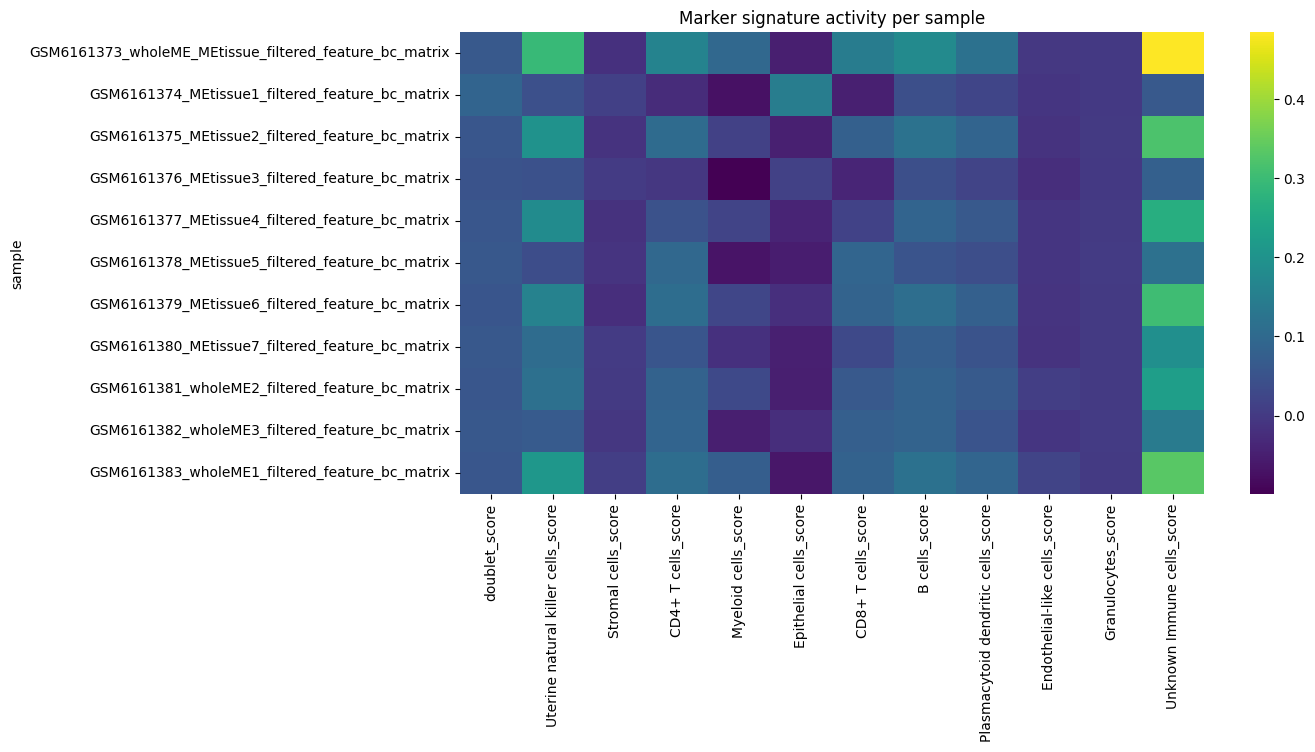

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.heatmap(scores_per_sample, cmap="viridis")
plt.title("Marker signature activity per sample")
plt.show()

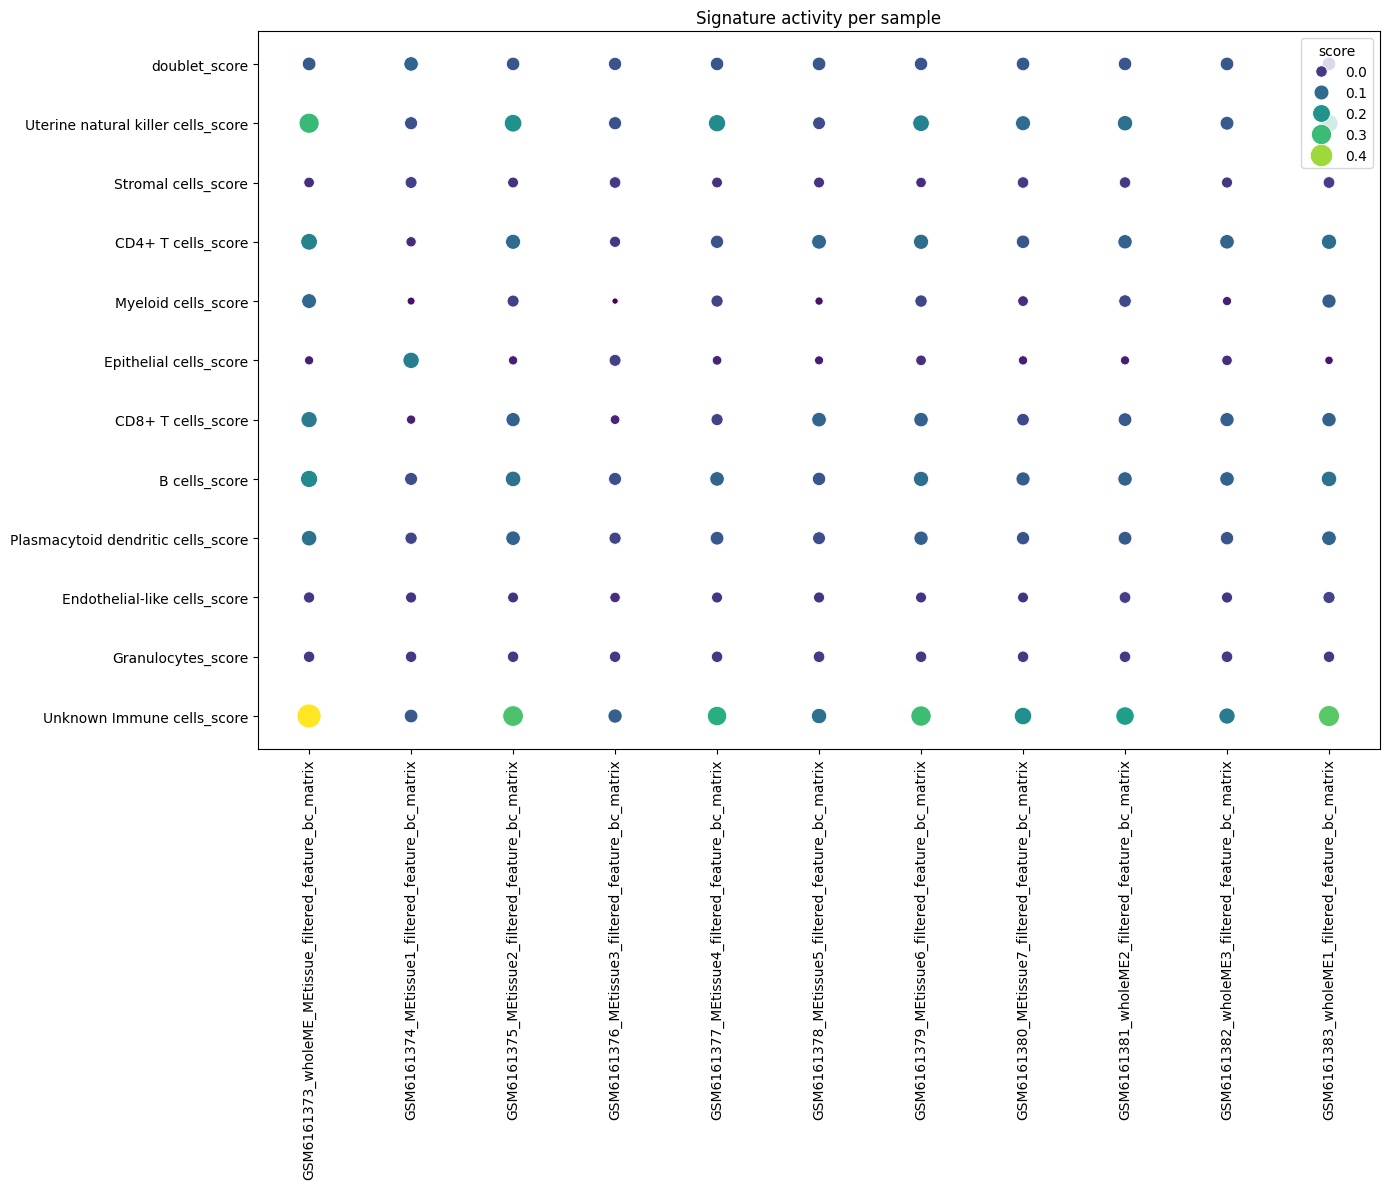

In [114]:
df_long = (
    scores_per_sample
    .reset_index()
    .melt(id_vars="sample", var_name="signature", value_name="score")
)
plt.figure(figsize=(14, 12))

sns.scatterplot(
    data=df_long,
    x="sample",
    y="signature",
    size="score",
    hue="score",
    sizes=(20, 300),
    palette="viridis",
    legend="brief"
)
plt.xticks(rotation=90)
plt.ylabel("")
plt.xlabel("")
plt.title("Signature activity per sample")
plt.tight_layout()
plt.show()

Unfortunetely, I can't make any conclusions which samples are diagnosed and which ones are not. 

To summarise, I'm able to analyse here three samples derived from eutopic endometrium shed from the uterine lining. If I'd like to continue this project I probably could first analyse control datasets, such as scRNA-seq from Control Endometrium with Eutopic Endometriosis - https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE179640, and then check if I classify as diagnosed that three samples from this study (GSE203191). So, do my three samples from GSE203191 look like eutopic endometriosis or control endometrium, according to a model trained only on GSE179640?